In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from utils import generate_caption
from cap_model_m1 import ResNetLSTMCaptionModel
from dataloader_hf import FlickrDataset
import torch
import pickle
from datasets import load_dataset

# Load dataset
ds = load_dataset("jxie/flickr8k")
test_ds = ds["test"]

# Load vocab
with open("/content/vocab-HF-8K.pkl", "rb") as f:
    vocab = pickle.load(f)

word2int = vocab["word2int"]
int2word = vocab["int2word"]

# Load model
model = ResNetLSTMCaptionModel(
    vocab_size=len(word2int),
    embed_dim=256,
    hidden_dim=512
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load("/content/m1_resnet_lstm.pth", map_location=device)
)

model = model.to(device)


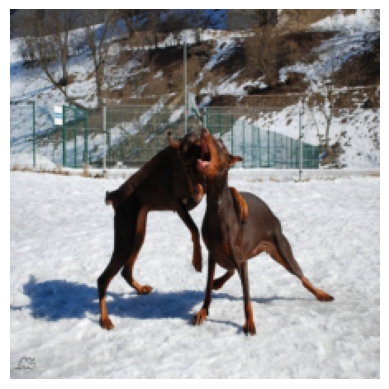

Ground Truth: <sos> the dogs are in the snow in front of a fence <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


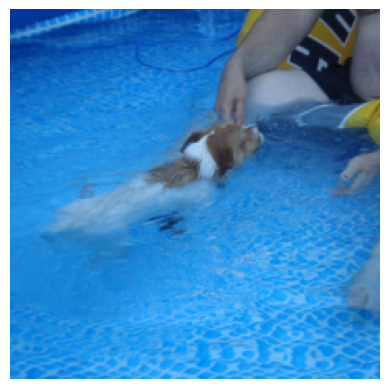

Ground Truth: <sos> a brown and white dog swimming towards some in the pool <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


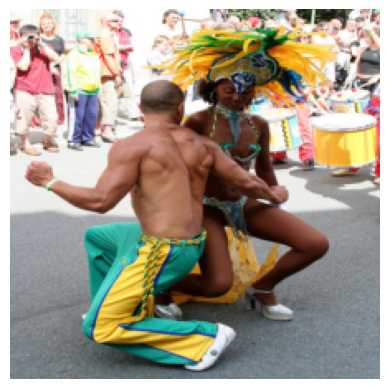

Ground Truth: <sos> a man and a woman in festive costumes dancing <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


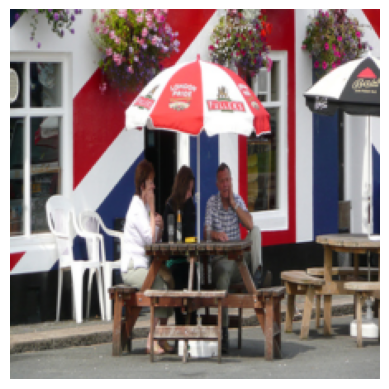

Ground Truth: <sos> a couple of people sit outdoors at a table with an umbrella and talk <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


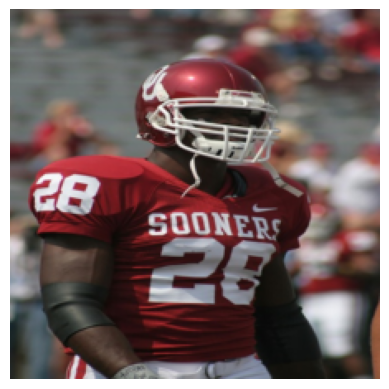

Ground Truth: <sos> a man is wearing a sooners red football shirt and helmet <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


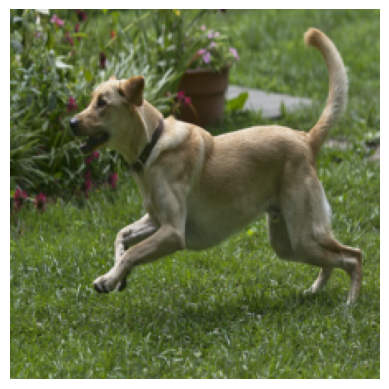

Ground Truth: <sos> a brown dog running <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


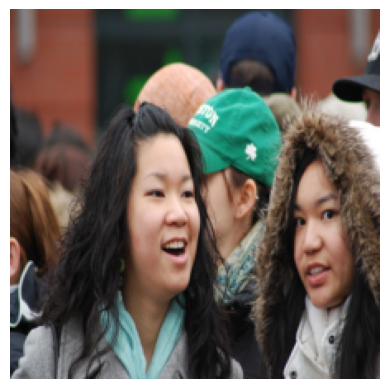

Ground Truth: <sos> a girl with dark brown hair and eyes in a blue scarf is standing next to a girl in a fur <unk> coat <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


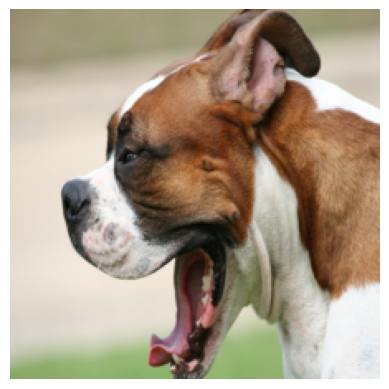

Ground Truth: <sos> a dog with its mouth <unk> <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


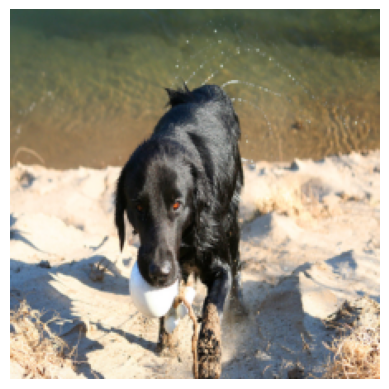

Ground Truth: <sos> a black dog emerges from the water onto the sand <unk> holding a white object in its mouth <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


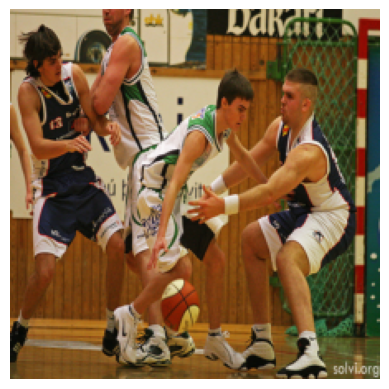

Ground Truth: <sos> a player from the white and green <unk> team dribbles down court <unk> by a player from the other team <unk> <eos>
Generated   : a man in a red shirt is standing on a red <unk>
------------------------------------------------------------


In [6]:
import matplotlib.pyplot as plt

dataset = FlickrDataset(test_ds, vocab_path="/content/vocab-HF-8K.pkl")

for i in range(10):
    image, caption_ids, _ = dataset[i]

    gt_caption = " ".join(
        [int2word[idx.item()] for idx in caption_ids if idx.item() in int2word]
    )

    pred_caption = generate_caption(
        model, image, word2int, int2word
    )

    img = image.clone()
    img = img.permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.show()

    print("Ground Truth:", gt_caption)
    print("Generated   :", pred_caption)
    print("-" * 60)

In [7]:
!pip install nltk rouge-score jiwer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=963ba8955679f5c8b2dfbbf910543003ec6a34575485c90e0338237535858d7a
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [3]:
import torch
import nltk
import numpy as np
import pickle

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from jiwer import wer

from datasets import load_dataset
from dataloader_hf import FlickrDataset
from cap_model_m1 import ResNetLSTMCaptionModel
from utils import generate_caption, compute_metrics


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load vocab
with open("/content/vocab-HF-8K.pkl", "rb") as f:
    vocab = pickle.load(f)

word2int = vocab["word2int"]
int2word = vocab["int2word"]

# Load model
model = ResNetLSTMCaptionModel(
    vocab_size=len(word2int),
    embed_dim=256,
    hidden_dim=512
)

model.load_state_dict(
    torch.load("/content/m1_resnet_lstm.pth", map_location=device)
)

model = model.to(device)
model.eval()

# Load test data
ds = load_dataset("jxie/flickr8k")
test_ds = ds["test"]

dataset = FlickrDataset(test_ds, vocab_path="/content/vocab-HF-8K.pkl")

# Metric storage
bleu1_scores, bleu4_scores, rouge_scores, wer_scores = [], [], [], []

NUM_SAMPLES = 100

for i in range(NUM_SAMPLES):
    image, caption_ids, _ = dataset[i]

    gt_caption = " ".join(
        [
            int2word[idx.item()]
            for idx in caption_ids
            if int2word[idx.item()] not in ["<sos>", "<eos>", "<pad>"]
        ]
    )

    pred_caption = generate_caption(
        model, image, word2int, int2word
    )

    b1, b4, r, w = compute_metrics(gt_caption, pred_caption)

    bleu1_scores.append(b1)
    bleu4_scores.append(b4)
    rouge_scores.append(r)
    wer_scores.append(w)

print("M1 Quantitative Results (Test Set)")
print(f"BLEU-1 : {np.mean(bleu1_scores):.4f}")
print(f"BLEU-4 : {np.mean(bleu4_scores):.4f}")
print(f"ROUGE-L: {np.mean(rouge_scores):.4f}")
print(f"WER    : {np.mean(wer_scores):.4f}")

M1 Quantitative Results (Test Set)
BLEU-1 : 0.2740
BLEU-4 : 0.0406
ROUGE-L: 0.3039
WER    : 0.9797
